# 3. Supervised Dimensional Reduction (PCA vs PLS)

Here, we perform unsupervised dimensional reduction (PCA) and supervised dimensional reduction (PLS) against the same data.

## Setting

First, install `PyTorchDecomp`.
Here, `scikit-learn` is also installed to visualize the data by t-SNE.

In [1]:
try:
    import torchdecomp
except ImportError:
    import subprocess
    # Check Python Version (>= 3.10)
    print(subprocess.run(["python", "-V"]))
    # Install PyTorch
    repo_url = "https://github.com/chiba-ai-med/PyTorchDecomp.git"
    subprocess.check_call(f"pip install git+{repo_url}", shell=True)

try:
    import sklearn
except ImportError:
    import subprocess
    # Check Python Version (>= 3.10)
    print(subprocess.run(["python", "-V"]))
    # Install Sklearn
    subprocess.check_call("pip install scikit-learn", shell=True)

## Package Loading

Then, load the necessary packages for data analysis, including `PyTorchDecomp`.

In [2]:
import torch
import torch.nn as nn
import torchdecomp as td
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Data Download

Here, the `MNIST` (handwritten characters) data provided by `TorchVision` is used, with only 5,000 data subsampled for demonstration purposes, as follows.

This dataset is further divided into 4,000 training data and 1,000 test data. PCA performs dimensionality reduction on the test data without using labels, and PLS learns a loading matrix on the only training data and then uses it to project the test data.

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



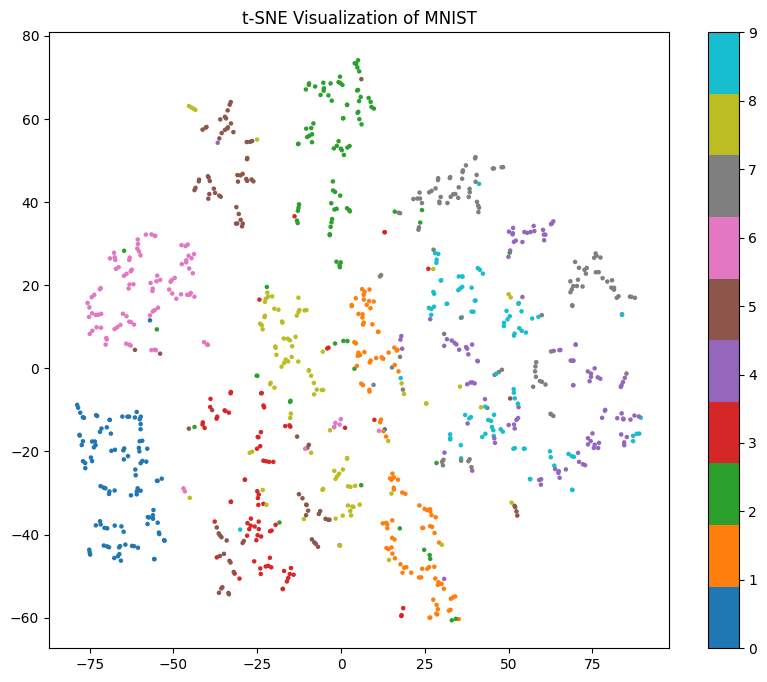

In [3]:
# Pre-processing Function
transform = transforms.ToTensor()

# Data Download
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Subsampling
torch.manual_seed(123456)
subset_indices = torch.randperm(len(mnist_dataset))[:5000]

subset_indices_train = torch.randperm(len(subset_indices))[:4000]
subset_indices_test = torch.randperm(len(subset_indices))[4000:]

mnist_subset_train = torch.utils.data.Subset(mnist_dataset, subset_indices_train)
mnist_subset_test = torch.utils.data.Subset(mnist_dataset, subset_indices_test)

all_data_train = torch.stack([sample[0] for sample in mnist_subset_train], dim=0)
all_data_test = torch.stack([sample[0] for sample in mnist_subset_test], dim=0)

# PyTorch Tensor to Numpy Array
data_train_np = all_data_train.numpy().reshape(all_data_train.size(0), -1)
data_test_np = all_data_test.numpy().reshape(all_data_test.size(0), -1)

# Numpy Array to PyTorch Tensor
data_train_torch = torch.tensor(data_train_np)
data_test_torch = torch.tensor(data_test_np)

# t-SNE
torch.manual_seed(123456)
embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(data_test_np)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=mnist_dataset.targets[subset_indices_test], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

### GPU Check and Setting

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

data_train_torch = data_train_torch.to(device)
data_test_torch = data_test_torch.to(device)

cpu


## PCA (Rec-mode)

Apply PCA to 1,000 test data as described in [tutorial 2](https://chiba-ai-med.github.io/PyTorchDecomp/tutorials.html).

### Normalization of data matrix

In [5]:
data_test_torch_norm = torch.nn.functional.normalize(data_test_torch, dim=0)

In [6]:
# Instantiation of RecLayer
torch.manual_seed(123456)
rec_layer = td.RecLayer(x=data_test_torch_norm, n_components=10)

# Setting Optimizer
optimizer = optim.SGD(rec_layer.parameters(), lr=2e-3)

# Weights for each objective function
weights = np.array([2, 1])
weights = weights / sum(weights)

# Iteration
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = rec_layer(data_test_torch_norm)
    # Loss
    ortho_loss_V = torch.norm(torch.eye(rec_layer.V.size(1)) - torch.mm(rec_layer.V.t(), rec_layer.V))
    loss = weights[0] * torch.sum((data_test_torch_norm - x_pred)**2) + weights[1] * ortho_loss_V
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

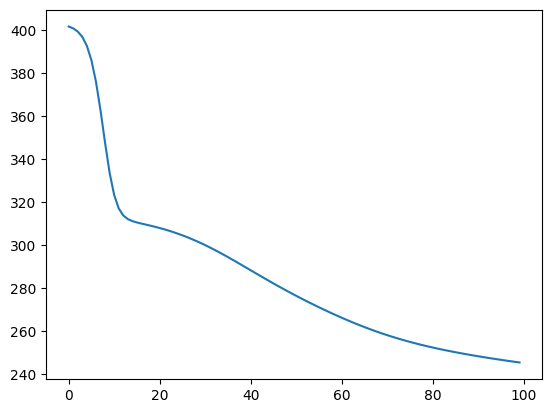

In [7]:
plt.plot(loss_array)

### Pattern Check

The scores ($XV$) seem to be able to extract patterns along with the differences in the `MNIST` numbers.

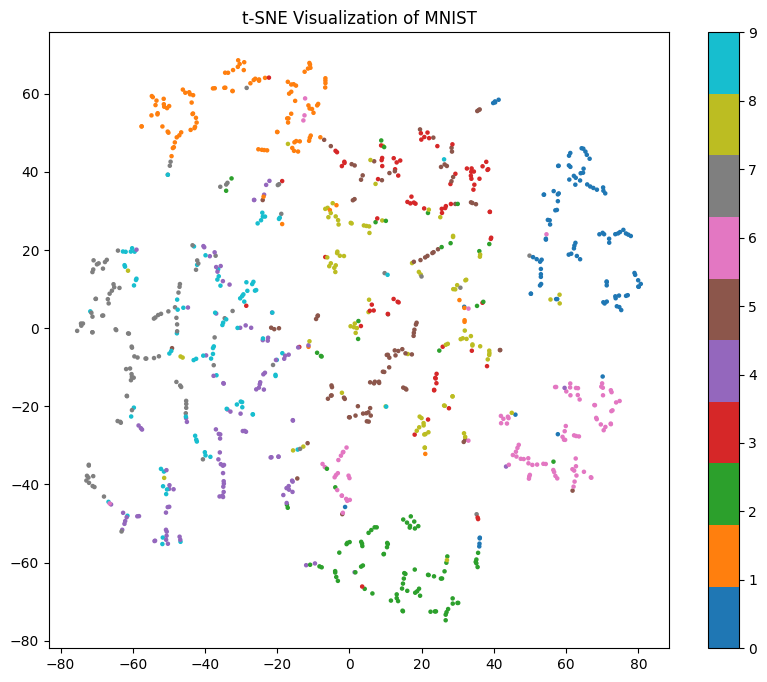

In [8]:
# t-SNE with PCA 
pca_score = data_test_torch.numpy() @ rec_layer.V.detach().numpy()
torch.manual_seed(123456)
pca_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(pca_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], c=mnist_dataset.targets[subset_indices_test], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## PLS

Unlike PCA using only the data matrix $X$, PLS is a supervised dimensionality reduction that reduces the dimension of $X$ by using a dummy variable matrix $Y$ generated from the labels.

First, normalization is performed so that the mean of the column vectors of $X$ and $Y$ are all zero.

### Normalization of data matrix

In [9]:
train_mean = torch.mean(data_train_torch, dim=0)
data_train_torch_norm = data_train_torch - train_mean
data_test_torch_norm = data_test_torch - train_mean

### Normalization of dummy variable matrix

In [10]:
target_y = td.create_dummy_matrix(mnist_dataset.targets[subset_indices_train])
target_y = torch.nn.functional.normalize(target_y, dim=0)

### Cross-product matrix

Then, the matrix product of $X$ and $Y$ is obtained.

In [11]:
xy = torch.mm(data_train_torch_norm.t(), target_y).t()
xy.size()

torch.Size([10, 784])

## PLS (Rec-mode)

PLS has Rec-mode and Factor-mode as PCA [tutorial 2](https://chiba-ai-med.github.io/PyTorchDecomp/tutorials.html). In the PLS (Rec-mode), $X^{T}Y$ is decomposed as follows:

$$
Y^{T} X = Y^{T} X V V^T
$$

, where $V$ is an $m \times k$ orthogonal matrix ($V^{T}V=I$).

In [12]:
# Instantiation of RecLayer
torch.manual_seed(123456)
rec_layer = td.RecLayer(x=xy, n_components=10)

# Setting Optimizer
optimizer = optim.SGD(rec_layer.parameters(), lr=1e-5)

# Weights for each objective function
weights = np.array([2, 1])
weights = weights / sum(weights)

# Iteration
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Forward
    xy_pred = rec_layer(xy)
    # Loss
    ortho_loss_V = torch.norm(torch.eye(rec_layer.V.size(1)) - torch.mm(rec_layer.V.t(), rec_layer.V))
    loss = weights[0] * torch.sum((xy - xy_pred)**2) + weights[1] * ortho_loss_V
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

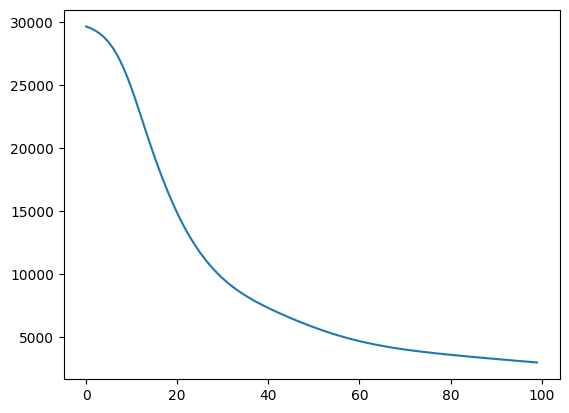

In [13]:
plt.plot(loss_array)

### Pattern Check

The scores ($XV$) seem to be able to extract patterns along with the differences in the `MNIST` numbers.

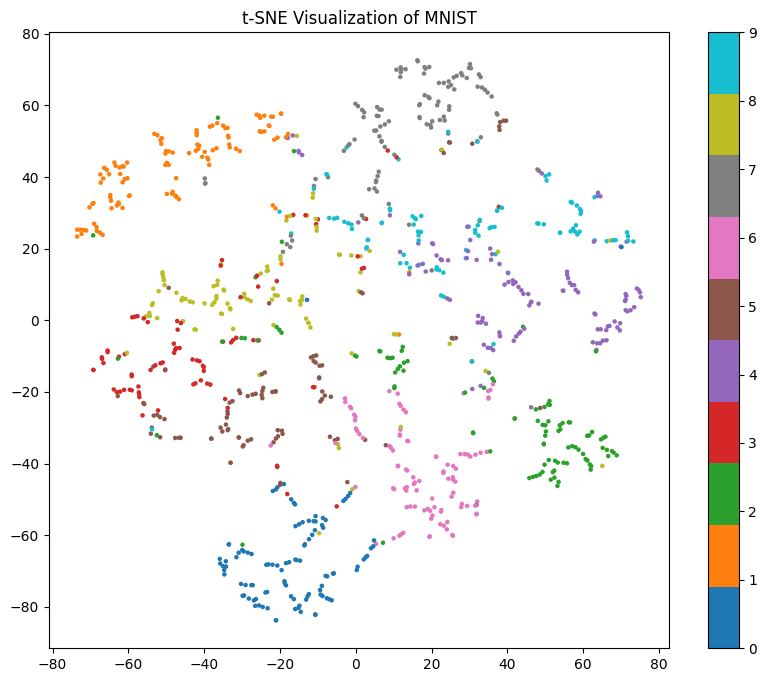

In [14]:
# t-SNE with PLS (Rec-mode)
pls_rec_score = data_test_torch.numpy() @ rec_layer.V.detach().numpy()
torch.manual_seed(123456)
pls_rec_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(pls_rec_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(pls_rec_embedding[:, 0], pls_rec_embedding[:, 1], c=mnist_dataset.targets[subset_indices_test], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## PLS (Factor-mode)

Similar to PCA, PLS also has another formulation to maximize the covariance of the scores of $X$ ($XV$) and the scores of $Y$ ($YW$) as follows.

$$
\{V,W\} = \max(\mathrm{tr}((XV)^T(YW)))
$$

In `PyTorchDecomp`, this can be expressed as an objective function in a straightforward manner; just change the reconstuction loss of PLS (Rec-mode) to `-torch.trace` as follows:

In [15]:
# Instantiation of FactorLayer
torch.manual_seed(123456)
factor_layer = td.FactorLayer(x=data_train_torch_norm, n_components=10)

# Setting Optimizer
optimizer = optim.SGD(factor_layer.parameters(), lr=1e+1)

# Weights for each objective function
weights = np.array([2, 1])
weights = weights / sum(weights)

# Iteration
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Forward
    score = factor_layer(data_train_torch_norm)
    # Loss
    ortho_loss_V = torch.norm(torch.eye(rec_layer.V.size(1)) - torch.mm(rec_layer.V.t(), rec_layer.V))
    loss = - weights[0] * torch.trace(torch.mm(score.t(), target_y)) + weights[1] * ortho_loss_V
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

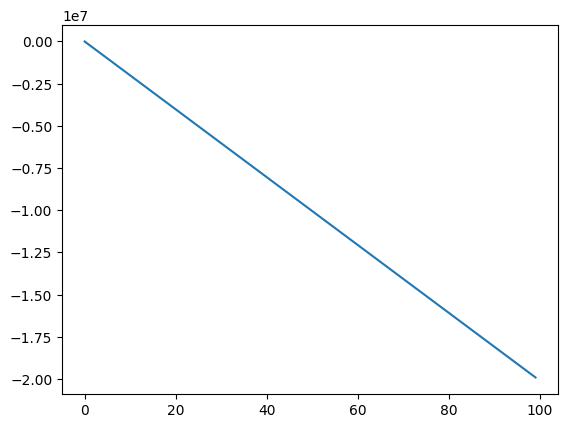

In [16]:
plt.plot(loss_array)

### Pattern Check

The scores ($XV$) seem to be able to extract patterns along with the differences in the `MNIST` numbers.

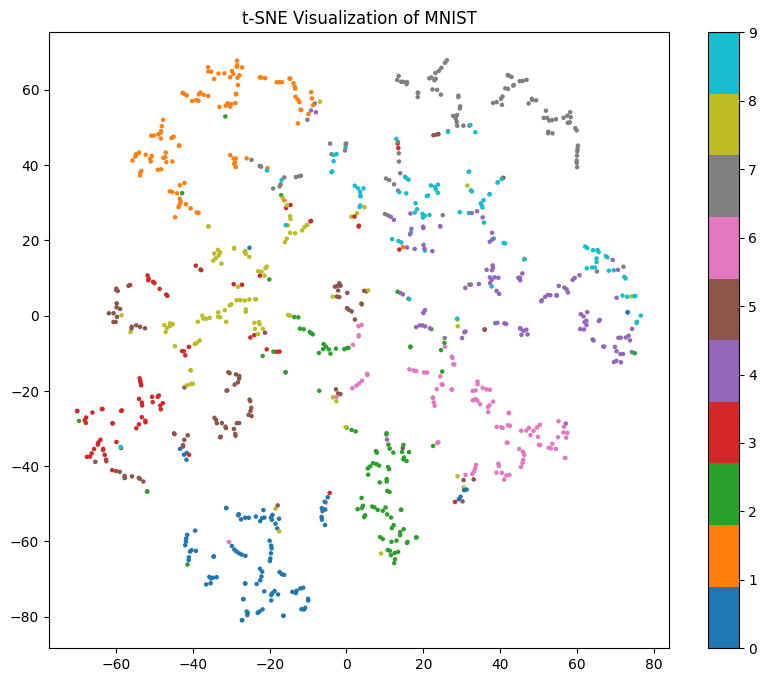

In [17]:
# t-SNE with PLS (Cov-mode)
pls_factor_score = data_test_torch.numpy() @ factor_layer.V.detach().numpy()
torch.manual_seed(123456)
pls_factor_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(pls_factor_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(pls_factor_embedding[:, 0], pls_factor_embedding[:, 1], c=mnist_dataset.targets[subset_indices_test], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## Reference

- **Principal Component Analysis (PCA) / Partial Least Squares (PLS)**
  - R. Arora, A. Cotter, K. Livescu and N. Srebro, Stochastic optimization for PCA and PLS, 2012 50th Annual Allerton Conference on Communication, Control, and Computing, 2012, 861-868. 2012